In [21]:
import  torch
from torch import cuda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim



In [22]:
if cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")    
    print("cuda not available") 

In [23]:
cuda.is_available()

True

In [24]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [25]:

import zipfile
from pathlib import Path


In [26]:
data_path = Path("data/")
image_path =data_path/"img_align_celeba.zip"


In [27]:
image_path

WindowsPath('data/img_align_celeba.zip')

In [28]:
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile("img_align_celeba.zip", "r") as zip_ref:
        print("Unzipping face data") 
        
        zip_ref.extractall(image_path)


data\img_align_celeba.zip directory exists.


In [29]:
from PIL import Image
import random

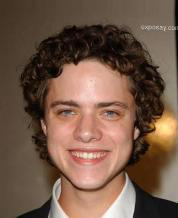

In [30]:
image_list =list(image_path.glob("*/*.jpg"))
len(image_list)
image_list[0].open()
a =random.choice(image_list)
img = Image.open(a)
img


In [31]:
#Initializing our HyperParameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 32*32
image_size = 64*64
batch_size = 32
input_channels = 1 # RGB channels
num_epochs = 500

In [32]:
dataset = datasets.ImageFolder(root=image_path,
                          transform=transforms.Compose([
                               transforms.Resize((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Grayscale(num_output_channels=1),
                               
                           ]))

torch.Size([32, 1, 64, 64])


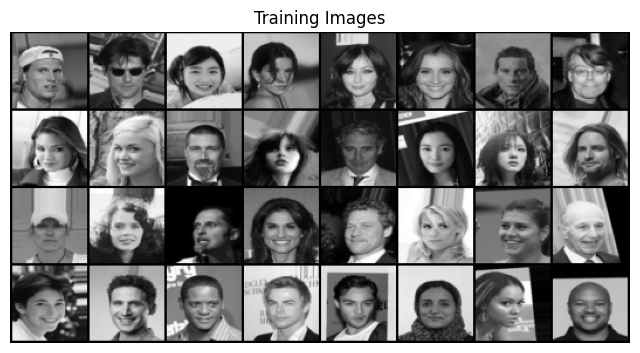

In [33]:
import torchvision.utils as vutils

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [34]:
# Initiallizing our Models 

discriminator = Discriminator(image_size).to(device)
generator = Generator(z_dim,image_size).to(device)
discriminator,generator

(Discriminator(
   (disc): Sequential(
     (0): Linear(in_features=4096, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=128, out_features=1, bias=True)
     (3): Sigmoid()
   )
 ),
 Generator(
   (gen): Sequential(
     (0): Linear(in_features=1024, out_features=256, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=256, out_features=4096, bias=True)
     (3): Tanh()
   )
 ))

In [35]:
#Setting up our Optimizer and Loss FUnctions

optm_disc = optim.Adam(discriminator.parameters(), lr=lr)
optm_gen = optim.Adam(generator.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0
fixed_noise = torch.randn((batch_size, z_dim)).to(device)


In [36]:
for epoch in range(num_epochs):
    for idx, (images, _) in enumerate(dataloader):
        batch = images.size(0)
        real = images.to(device)
        real = real.view(-1, 4096).to(device)
        # print(real.shape)
        # Real images
        #V(G,D) [logD(x)]+[log(1−D(G(z)))]

        real_output = discriminator(real).view(-1)
        # print(f"real size:{real_output.shape}")

        #for fake
        noise = torch.randn(batch, z_dim).to(device)
        # print(f"noise shape is:{noise.shape}")
        fake = generator(noise)
        # print(f"fake shape is:{fake.shape}")

        fake_discriminator = discriminator(fake).view(-1)
        # print(f"fake_disc is:{fake_discriminator.shape}")

        #Loss functions check
        lossD_real = criterion(real_output, torch.ones_like(real_output))
        lossD_fake = criterion(fake_discriminator, torch.zeros_like(fake_discriminator))
        loss_Discriminator = (lossD_real+lossD_fake)/2

        # print(lossD_fake,lossD_real)

        #Optimizing our discriminator for training 
        discriminator.zero_grad()
        loss_Discriminator.backward(retain_graph=True)
        optm_disc.step()



        ##Doing same for GENERATOR training
        gen_fake = discriminator(fake).view(-1)
        lossG = criterion(gen_fake, torch.ones_like(gen_fake))
        generator.zero_grad()
        lossG.backward()
        optm_gen.step()

        if idx == 0:
                    print(
                        f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(dataloader)} \
                            Loss D: {loss_Discriminator:.4f}, loss G: {lossG:.4f}"
                    )

                    with torch.no_grad():
                        fake = generator(fixed_noise).reshape(-1, 1, 64, 64)
                        # print(fake.shape)
                        data = real.reshape(-1, 1, 64, 64)
                        print(data.shape)
                        
                        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                        img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                        writer_fake.add_image(
                            "celebface Fake Images", img_grid_fake, global_step=step
                        )
                        writer_real.add_image(
                            "celebface Real Images", img_grid_real, global_step=step
                        )
                        step += 1
        

        

Epoch [0/500] Batch 0/66                             Loss D: 0.7143, loss G: 0.8677
torch.Size([32, 1, 64, 64])
Epoch [1/500] Batch 0/66                             Loss D: 0.1160, loss G: 2.9387
torch.Size([32, 1, 64, 64])
Epoch [2/500] Batch 0/66                             Loss D: 0.0393, loss G: 5.1811
torch.Size([32, 1, 64, 64])
Epoch [3/500] Batch 0/66                             Loss D: 0.0275, loss G: 5.6539
torch.Size([32, 1, 64, 64])
Epoch [4/500] Batch 0/66                             Loss D: 0.0354, loss G: 5.0750
torch.Size([32, 1, 64, 64])
Epoch [5/500] Batch 0/66                             Loss D: 0.0841, loss G: 3.1660
torch.Size([32, 1, 64, 64])
Epoch [6/500] Batch 0/66                             Loss D: 0.1229, loss G: 2.1097
torch.Size([32, 1, 64, 64])
Epoch [7/500] Batch 0/66                             Loss D: 0.1009, loss G: 2.0810
torch.Size([32, 1, 64, 64])
Epoch [8/500] Batch 0/66                             Loss D: 0.0557, loss G: 2.9488
torch.Size([32, 1, 6